# Serverless inference deployment 

Setup Constants. Be sure to adjust the S3 location accordingly.

In [3]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import botocore
import json

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.Session().region_name

# S3 bucket and folders for saving model artifacts.
# Feel free to specify different bucket/folders here if you wish.
bucket = sess.default_bucket()
folder = "BIRD-Sagemaker-Serverless"
compilation_output_sub_folder = folder + "/compilation-output"

# S3 Location to save the model artifact after compilation
s3_compilation_output_location = "s3://{}/{}".format(bucket, compilation_output_sub_folder)
s3_compilation_output_location

's3://sagemaker-us-east-1-666649746519/BIRD-Sagemaker-Serverless/compilation-output'

# Deploy Model

First create a serverless config indicating memory and the max concurrent invocations the serverless endpoint can process

In [15]:
import sagemaker.serverless as Serverless

serverless_inf_config = Serverless.ServerlessInferenceConfig(memory_size_in_mb=4096, max_concurrency=5)

Recreate the model object from an S3 artifact and deploy

In [17]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(
    model_data=f's3://{bucket}/{folder}/BIRD-Sagemaker-Serverless-2022-05-17-17-46-43-696/output/model.tar.gz', 
    role=role,
    framework_version="2.3.0")


predictor = model.deploy(serverless_inference_config=serverless_inf_config)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!

# Test Model

Similar to the real time inference notbook, here we use the endpoint and get sample predictions. Recreate the predictor from an endpoint or use the one generated in the above cell

In [38]:
from sagemaker import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

serializer = IdentitySerializer(content_type="application/x-image")
deserializer = JSONDeserializer(accept='application/json')

predictor = Predictor(endpoint_name='tensorflow-inference-2022-05-17-18-13-25-484',serializer = serializer,deserializer = deserializer )

The model used in this sample was **only trained on classes 13, 17, 35, 36, 47, 68, 73, 87** so we can only get predictions for those. Here we get the names of those classes to see what we can predict.

In [49]:
import cv_utils

classes_file = f"s3://{bucket}/{folder}/full/data/classes.txt"
classes = [13, 17, 35, 36, 47, 68, 73, 87]

possible_classes= cv_utils.get_classes_as_list(classes_file,classes)

possible_classes

['013.Bobolink', '017.Cardinal', '035.Purple_Finch', '036.Northern_Flicker', '047.American_Goldfinch', '068.Ruby_throated_Hummingbird', '073.Blue_Jay', '087.Mallard']


Get local sample data to get predictions from

In [90]:
sample_images = cv_utils.get_n_random_images(bucket,prefix=f'{folder}/outputs/test',n=2)

local_paths = cv_utils.download_images_locally(bucket,sample_images)
print(local_paths)


['./inference-test-data/Mallard_0035_77095.jpg',
 './inference-test-data/Cardinal_0016_17862.jpg']

Get predictions from the local images

./inference-test-data/Mallard_0035_77095.jpg
[[4.176658582417871e-16, 7.495624837335838e-17, 1.4640038051004522e-17, 3.6592275954616964e-16, 5.46370098415596e-14, 6.173631484501785e-12, 2.898198784369484e-14, 1.0]]
7


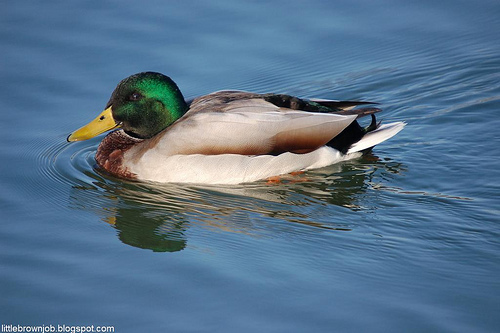

Class: 087.Mallard, confidence: 1.00
./inference-test-data/Cardinal_0016_17862.jpg
[[3.777129128944897e-15, 1.0, 4.8901969279535606e-11, 2.269137241914859e-17, 2.0335677586302836e-10, 6.360895967935654e-13, 1.5814709906762127e-14, 2.3838656625918307e-18]]
1


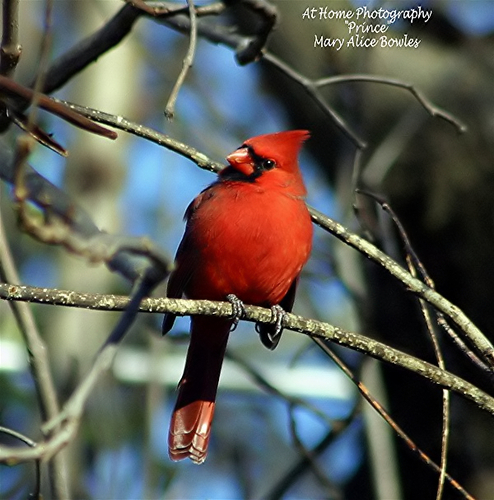

Class: 017.Cardinal, confidence: 1.00


In [93]:
for inputfile in local_paths:
    print(inputfile)
    cv_utils.predict_bird_from_file(inputfile,predictor,possible_classes)